#Install libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')

    !pip install torchtext --upgrade --q
    !pip install torchmetrics --q
    !pip install --quiet torch-lr-finder --q
    !pip install wandb --q --upgrade

    basepath = '/content/drive/MyDrive/NLP_UTD/Assignments/Assignment_7'
    sys.path.append('/content/drive/MyDrive/NLP_UTD/custom-functions')
    
else:
    basepath = '/home/harpreet/Insync/google_drive_shaannoor/data'
    sys.path.append('/home/harpreet/Insync/google_drive_shaannoor/data/custom-functions')   

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 65.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.5/199.5 kB 23.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.0 MB/s eta 0:00:00


In [3]:
from pathlib import Path
base_folder = Path(basepath)
data_folder = base_folder
model_folder = base_folder
custom_functions = '/content/drive/MyDrive/NLP_UTD/custom-functions'
# sys.path.append(str(custom_functions))
sys.path

['/content',
 '/env/python',
 '/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/usr/local/lib/python3.10/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.10/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/drive/MyDrive/NLP_UTD/custom-functions']

In [4]:
# Importing the necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F


import torchmetrics
from torch.utils.data import Dataset, DataLoader
from torchmetrics.classification import Accuracy
from sklearn.model_selection import train_test_split

import random
import numpy as np
import joblib

from types import SimpleNamespace
from functools import partial
from pathlib import Path
import sys
from sklearn.metrics import accuracy_score, f1_score, hamming_loss
import matplotlib.pyplot as plt

import wandb
import ast
from torch_lr_finder import LRFinder
from Trainer_v4 import Trainer
from data_preparation_HW7 import *
from ff_sequential_model_v1 import MLPCustom
from  torchmetrics.functional.classification import multilabel_f1_score, multilabel_hamming_distance
from torchmetrics.classification import  MultilabelHammingDistance
from torchmetrics import HammingDistance

/usr/local/lib/python3.10/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [5]:
Trainer.set_seed()
df = joblib.load(data_folder/'df_multilabel_hw_cleaned.joblib')
# df = df.sample(frac = 0.3, random_state = 42, replace = False)

In [6]:
import ast
df['Tag_Number'] = df['Tag_Number'].apply(ast.literal_eval)
print(type(df['Tag_Number'][0][1]))

<class 'int'>


In [7]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
one_hot = mlb.fit_transform(df['Tag_Number'])
df['Tags_Encoded'] = pd.Series(one_hot.tolist())


x_train, x_val_test, y_train, y_val_test = train_test_split(df['cleaned_text'], df['Tags_Encoded'], test_size = 0.4, random_state = 42)
x_valid, x_test, y_valid, y_test = train_test_split(x_val_test, y_val_test, test_size = 0.5, random_state = 42)

x_train = x_train.values
x_valid = x_valid.values
x_test = x_test.values

y_train = y_train.values
y_valid = y_valid.values
y_test = y_test.values

print("Train set shape:", x_train.shape, y_train.shape)
print("Valid set shape:", x_valid.shape, y_valid.shape)
print("Test set shape:", x_test.shape, y_test.shape)

Train set shape: (28456,) (28456,)
Valid set shape: (9485,) (9485,)
Test set shape: (9486,) (9486,)


In [8]:
trainset = CustomDataset(x_train, y_train)
validset = CustomDataset(x_valid, y_valid)
testset = CustomDataset(x_test, y_test)

multilabel_vocab = get_vocab(trainset, min_freq=2)

In [9]:
from gensim.models import KeyedVectors
cbow_vectors_HW7 = KeyedVectors.load(str(base_folder/'cbow_model_AJ.bin'))
pretrained_weights_tensor, words_found, words_not_found = get_pretrained_weights(multilabel_vocab, cbow_vectors_HW7)

In [10]:
pretrained_weights_tensor.shape

torch.Size([90287, 300])

In [11]:
type(pretrained_weights_tensor), words_found, words_not_found

(torch.Tensor, 33785, 56502)

In [40]:
hyperparameters = SimpleNamespace(
    # for model
    EMBED_DIM=300,
    VOCAB_SIZE=len(multilabel_vocab),
    OUTPUT_DIM=10,
    HIDDEN_SIZES_LIST=[200],
    DPROB_LIST=[0.0],
    NON_LINEARITY=nn.ReLU(),
    BATCH_NORM=False,

    # for training
    INITIALIZATION ='kaiming',
    EPOCHS=50,
    BATCH_SIZE=128,
    LEARNING_RATE=0.001,
    DATASET='Multi-label',
    ARCHITECTURE='embed_layer-ffn',

    # for optimizer
    OPTIMIZER='AdamW',
    MOMENTUM = 0,
    NESTEROV = False,
    WEIGHT_DECAY = 0.000,

    # gradient clipping
    CLIP_TYPE='norm',
    CLIP_VALUE=2,

    # early stopping
    EARLY_STOP_PATIENCE=5,
    SCHEDULER_PATIENCE=5,
    SCHEDULER_FACTOR=0.1,


    #scheduler
    SCHEDULER = 'None',
    USE_PRE_TRAINED_WEIGHTS=True,
    PRETRAINED_WEIGHTS=pretrained_weights_tensor,
    FREEZE_PRETRAINED=False,
    )

In [41]:
# Variables
project_name = "HW7_Regularization_Multilabel_v1"
run_name = "exp8"
run_folder = model_folder / run_name
run_folder.mkdir(exist_ok=True)
log_frequency = 5

In [42]:
# # run 1 - based on default initialization
# # Notes: Final Learning rate was set to 0.01

# # run 2 - add dropout
# hyperparameters.LEARNING_RATE = 0.01   
# hyperparameters.DPROB_LIST=[0.5] 

# # run 3 - remove dropout, add weight decay
# hyperparameters.WEIGHT_DECAY = 1
# hyperparameters.DPROB_LIST=[0] 

# # run 4 - remove dropout, add weight decay
# hyperparameters.WEIGHT_DECAY = 0.1

# # run 5 - increase batch size to 256
# hyperparameters.BATCH_SIZE = 256

# # run 6 - One cyucle scheduler
# hyperparameters.LEARNING_RATE = 0.001   
# hyperparameters.WEIGHT_DECAY = 10
# hyperparameters.SCHEDULER='OneCyclicLR'
# hyperparameters.SCHEDULER_MAX_LR=0.01
# hyperparameters.SCHEDULER_DIV_FACTOR=25
# hyperparameters.SCHEDULER_FINAL_DIV_FACTOR=1e3
# hyperparameters.EPOCHS = 10

# #  run 7 - use pre-trained weights but freeze teh weights - model will 
# hyperparameters.USE_PRE_TRAINED_WEIGHTS = True
# hyperparameters.FREEZE_PRETRAINED = True

# run 8 - Unfreeze the weights
hyperparameters.FREEZE_PRETRAINED = False

In [43]:
# Fix seed value
Trainer.set_seed()

collate_fn = partial(collate_batch, vocab=multilabel_vocab)

# Data Loader
train_loader, valid_loader = get_loaders(trainset=trainset, validset=validset, 
                                         batch_size_=hyperparameters.BATCH_SIZE,
                                         collate_fn=collate_fn)


# cross entropy loss function
loss_function = nn.BCEWithLogitsLoss()

# model
model_multilabel_hw7 = MLPCustom(
    hyperparameters.EMBED_DIM,
    hyperparameters.VOCAB_SIZE,
    hyperparameters.HIDDEN_SIZES_LIST,
    hyperparameters.DPROB_LIST,
    hyperparameters.OUTPUT_DIM,
    hyperparameters.NON_LINEARITY,
    hyperparameters.BATCH_NORM,
    hyperparameters.USE_PRE_TRAINED_WEIGHTS,
    hyperparameters.PRETRAINED_WEIGHTS,
    hyperparameters.FREEZE_PRETRAINED,
)


def init_weights(m):
    if type(m) == nn.Linear: 
        torch.nn.init.kaiming_normal_(m.weight)
        torch.nn.init.zeros_(m.bias)

# apply initialization recursively  to all modules
if hyperparameters.INITIALIZATION == 'kaiming':
    model_multilabel_hw7.apply(init_weights)


# OPTIMIZERS
def get_optimizer():
    if hyperparameters.OPTIMIZER == "SGD":
        optimizer = torch.optim.SGD(
            model_multilabel_hw7.parameters(),
            lr=hyperparameters.LEARNING_RATE,
            momentum=hyperparameters.MOMENTUM,
            nesterov=hyperparameters.NESTEROV,
        )
    else:
        optimizer = torch.optim.Adam(
            model_multilabel_hw7.parameters(), lr=hyperparameters.LEARNING_RATE
        )
    return optimizer


optimizer = get_optimizer()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [44]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [45]:
model_multilabel_hw7

MLPCustom(
  (non_linearity): ReLU()
  (embedding): EmbeddingBag(90287, 300, mode='mean')
  (module_list): ModuleList(
    (0): Linear(in_features=300, out_features=200, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=200, out_features=10, bias=True)
  )
)

In [46]:
trainer = Trainer(
    model=model_multilabel_hw7, optimizer=optimizer, criterion=loss_function, device=device
)

# set loaders
trainer.set_loaders(train_loader, valid_loader)

In [47]:
# trainer.lr_finder_range_test(trainer.train_loader)

In [48]:
# reset learning rate based on learning rate finder
# hyperparameters.LEARNING_RATE = 1.56E+00

In [49]:
# Reset Optimizer
trainer.set_optimizer(get_optimizer())

# set metric -- optional
train_metric = Accuracy(task='multilabel',num_labels=10)
valid_metric = Accuracy(task='multilabel',num_labels=10)
trainer.set_metric(train_metric.to(device), valid_metric.to(device))

# set checkpoint -- OPTIONAL
trainer.set_checkpoint(save_path=run_folder,
                       save_best=True, save_every_n_epochs=5, save_last_epoch=True)

# set early stopping
trainer.set_early_stopping(patience = hyperparameters.EARLY_STOP_PATIENCE)

# set gradient clipping
# trainer.set_gradient_clipping(hyperparameters.CLIP_TYPE, hyperparameters.CLIP_VALUE, norm_type=2)

# set scheduler
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(trainer.optimizer, patience=hyperparameters.SCHEDULER_PATIENCE,
#                                           factor=hyperparameters.SCHEDULER_FACTOR)

steps_per_epoch = len(trainer.train_loader)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(trainer.optimizer, 
#                                                 hyperparameters.SCHEDULER_MAX_LR, 
#                                                 steps_per_epoch=steps_per_epoch,
#                                                 epochs=hyperparameters.EPOCHS,
#                                                 div_factor=hyperparameters.SCHEDULER_DIV_FACTOR,
#                                                 final_div_factor=hyperparameters.SCHEDULER_FINAL_DIV_FACTOR)

# trainer.set_lr_scheduler(scheduler=scheduler)

In [50]:
trainer.sanity_check(num_classes=2)

Actual loss: 0.6937976555096611
Expected Theoretical loss: 0.6931471805599453


In [51]:
# set wandb -- OPTIONAL
trainer.set_wandb(
    project_name=project_name,
    run_name=run_name,
    config=hyperparameters,
    log_batch=True,
    log_frequency=log_frequency,
)

wandb: Currently logged in as: jyotsna999. Use `wandb login --relogin` to force relogin


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


In [52]:
trainer.train(num_epochs=hyperparameters.EPOCHS,multilabel=True)

Epoch 1/50 - Train Loss: 0.2813, Train Metric: 0.8918, Train Time: 0:01:59.104115
Epoch 1/50 - Val Loss: 0.1638, Val Metric: 0.9384, Val Time: 0:00:11.807239
Current Learning rate is 0.001

Epoch 2/50 - Train Loss: 0.1289, Train Metric: 0.9517, Train Time: 0:01:46.463452
Epoch 2/50 - Val Loss: 0.1240, Val Metric: 0.9540, Val Time: 0:00:10.981736
Current Learning rate is 0.001

Epoch 3/50 - Train Loss: 0.0902, Train Metric: 0.9679, Train Time: 0:01:47.869525
Epoch 3/50 - Val Loss: 0.1067, Val Metric: 0.9614, Val Time: 0:00:10.980482
Current Learning rate is 0.001

Epoch 4/50 - Train Loss: 0.0665, Train Metric: 0.9774, Train Time: 0:01:56.538253
Epoch 4/50 - Val Loss: 0.1021, Val Metric: 0.9638, Val Time: 0:00:11.291002
Current Learning rate is 0.001

Epoch 5/50 - Train Loss: 0.0506, Train Metric: 0.9838, Train Time: 0:01:51.896746
Epoch 5/50 - Val Loss: 0.1000, Val Metric: 0.9657, Val Time: 0:00:11.415014
Current Learning rate is 0.001

EarlyStopping counter: 1 out of 5
Epoch 6/50 - Tra

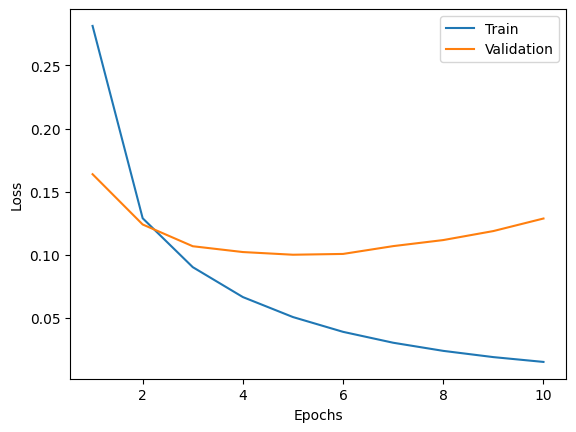

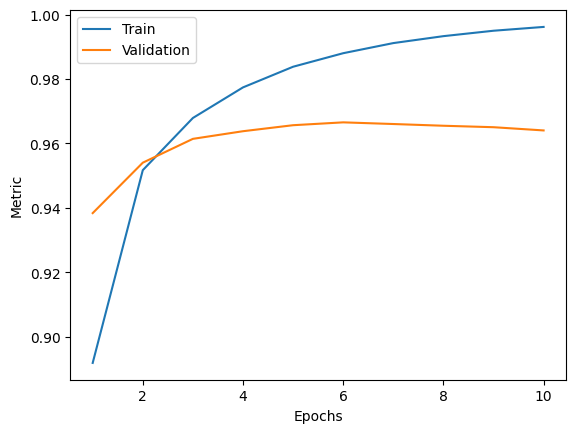

In [53]:
trainer.plot_history()

In [55]:
testset = CustomDataset(x_test, y_test)

In [56]:
test_loader = get_test_loaders(testset, batch_size_=hyperparameters.BATCH_SIZE,
                               collate_fn=collate_fn)

In [57]:
trainer.timestamp

'2023-04-27_23-32-26'

In [58]:
file = 'checkpoint_' + str(trainer.timestamp) + '_best.pt'
trainer.load_checkpoint(run_folder /file)

Loaded checkpoint from '/content/drive/MyDrive/NLP_UTD/Assignments/Assignment_7/exp8/checkpoint_2023-04-27_23-32-26_best.pt'.


In [59]:
# Get the prediction and accuracy for the test dataset
predictions_train, target_train = trainer.predict(train_loader, return_targets=True, multilabel = True)
predictions_valid, target_valid = trainer.predict(valid_loader, return_targets=True, multilabel = True)
predictions_test, target_test = trainer.predict(test_loader, return_targets=True, multilabel = True)

In [60]:
print(predictions_train.shape)
print(target_train.shape)
print(predictions_test.shape)
print(target_test.shape)
print(predictions_valid.shape)
print(target_valid.shape)

torch.Size([28456, 10])
torch.Size([28456, 10])
torch.Size([9486, 10])
torch.Size([9486, 10])
torch.Size([9485, 10])
torch.Size([9485, 10])


In [61]:
metric = torchmetrics.functional.accuracy
acc_train = metric(predictions_train, target_train,
                   task='multilabel', num_labels=10)
acc_valid = metric(predictions_valid, target_valid,
                   task='multilabel', num_labels=10)
acc_test = metric(predictions_test, target_test,
                  task='multilabel', num_labels=10)

In [62]:
# Print Test Accuracy
print('Test accuracy', acc_test * 100)
print('Train accuracy', acc_train * 100)
print('Valid accuracy', acc_valid * 100)

Test accuracy tensor(96.3747)
Train accuracy tensor(98.8677)
Valid accuracy tensor(96.5662)


In [63]:
wandb.log({'Best_test_Acc': acc_test})
wandb.log({'Best_train_Acc': acc_train})
wandb.log({'Best_valid_Acc': acc_valid})

In [64]:
wandb.finish()

Best_test_Acc,▁
Best_train_Acc,▁
Best_valid_Acc,▁
train_epoch_loss,█▄▃▂▂▂▁▁▁
train_epoch_metric,▁▅▆▇▇████
val_epoch_loss,█▄▂▁▁▁▂▂▃
val_epoch_metric,▁▅▇▇█████
Best_test_Acc,0.96375
Best_train_Acc,0.98868
Best_valid_Acc,0.96566
train_epoch_loss,0.01889


In [65]:
%wandb jyotsna999/HW7_Regularization_Multilabel_v1

In [68]:
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono
  fonts-texgyre fonts-urw-base35 javascript-common libapache-pom-java
  libcommons-logging-java libcommons-parent-java libfontbox-java libfontenc1
  libgs9 libgs9-common libharfbuzz-icu0 libidn11 libijs-0.35 libjbig2dec0
  libjs-jquery libkpathsea6 libpdfbox-java libptexenc1 libruby2.7 libsynctex2
  libteckit0 libtexlua53 libtexluajit2 libwoff1 libzzip-0-13 lmodern
  poppler-data preview-latex-style rake ruby ruby-minitest ruby-net-telnet
  ruby-power-assert ruby-test-unit ruby-xmlrpc ruby2.7 rubygems-integration
  t1utils teckit tex-common tex-gyre texlive-base texlive-binaries
  texlive-latex-base texlive-latex-extra texlive-latex-recommended
  texlive-pictures tipa xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf

In [69]:
!jupyter nbconvert --to pdf /content/drive/MyDrive/NLP_UTD/Assignments/Assignment_7/JyotsnaNagaprasad_Ambekar_HW7_task3_part_b.ipynb

[NbConvertApp] Converting notebook /content/drive/MyDrive/NLP_UTD/Assignments/Assignment_7/JyotsnaNagaprasad_Ambekar_HW7_task3_part_b.ipynb to pdf
[NbConvertApp] Support files will be in JyotsnaNagaprasad_Ambekar_HW7_task3_part_b_files/
[NbConvertApp] Making directory ./JyotsnaNagaprasad_Ambekar_HW7_task3_part_b_files
[NbConvertApp] Making directory ./JyotsnaNagaprasad_Ambekar_HW7_task3_part_b_files
[NbConvertApp] Writing 82836 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 112942 bytes to /content/drive/MyDrive/NLP_UTD/Assignments/Assignment_7/JyotsnaNagaprasad_Ambekar_HW7_task3_part_b.pdf
